In [1]:
import sys
import os
import numpy as np
sys.path.insert(0, r'D:\uni\Masterarbeit\Code\auswertung')
import auswertung_ma
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from auswertung_ma import f_exp, f_poly, f_poly_long

In [2]:
p_track = r'D:\Uni\Masterarbeit\Daten\Track'
# c = 3, rtc(0, 10), ohne break
dic3_track_wob2 = {}

dirs3t_wob2 = [d for d in os.listdir(p_track) if 'Track_woB2_C3' in d]

for ho in dirs3t_wob2:
    number_nodes = int(ho.split('_')[3])
    print(number_nodes)
    p_konfig = os.path.join(p_track, ho, os.listdir(os.path.join(p_track,ho))[0])
    
    df = auswertung_ma.read_tracking_files(p_konfig, read_opt=True, read_lp=True, read_constr=True)
    df['anteil_opt'] = df['sum_opt[s]'] / df['total_lp[s]']
    df['anteil_loop'] = df['lp_teil_loop[s]'] / df['total_lp[s]']
    df['anteil_opt_an_loop'] = df['sum_opt[s]'] / df['lp_teil_loop[s]']
    
    dic3_track_wob2[number_nodes] = df.mean()
    
ns_3t_wob2 = sorted(list(dic3_track_wob2.keys()))

# brauche die constr, die jetzt aber nicht mehr der constr anzahl entsprechen, sondern der Anzahl Iterationen
mean_lp_constrs_3t_wob2 = [dic3_track_wob2[n].lp_constraint_counter for n in ns_3t_wob2]
mean_total_lp_3t_wob2 = np.array([dic3_track_wob2[n]['total_lp[s]'] for n in ns_3t_wob2])
mean_sum_constr_3t_wob2 = [[dic3_track_wob2[n]['sum_add_constr[s]'] for n in ns_3t_wob2]]
mean_teil_loop_3t_wob2 = [[dic3_track_wob2[n]['lp_teil_loop[s]'] for n in ns_3t_wob2]]
mean_sum_opt_3t_wob2 = [dic3_track_wob2[n]['sum_opt[s]'] for n in ns_3t_wob2]

# anteil an ganzzahligen LP-Variablen
mean_anteil_lp_ganz_3t_wob2 = [dic3_track_wob2[n]['anteil_lp_int'] for n in ns_3t_wob2]
print(mean_anteil_lp_ganz_3t_wob2)

10
160
20
320
40
640
80
[0.9610010111219475, 0.9316001387897124, 0.934587045015427, 0.9375368474698789, 0.9429060825183124, 0.9464800080132616, 0.9468345656112633]


# Laufzeit

In [6]:
# misch fkt zum fitten
def f_misch(n, a, b, c, d):
    return c * (n ** b) * np.exp(a * (n ** d))

Text(0.5, 1.0, 'Laufzeit LP-Approx')

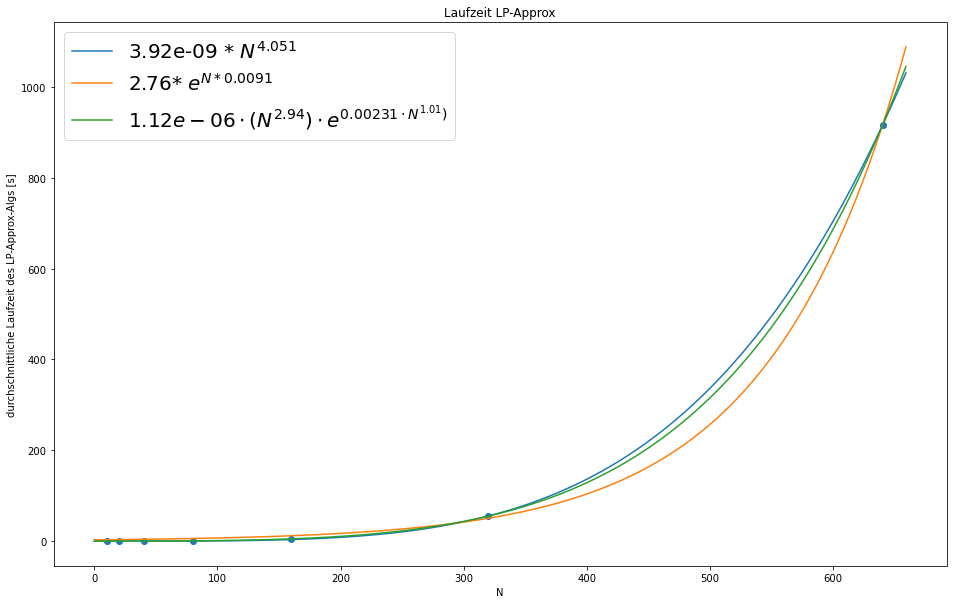

In [34]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(ns_3t_wob2, mean_total_lp_3t_wob2)
popt_poly, pcov_poly = curve_fit(f_poly, ns_3t_wob2, mean_total_lp_3t_wob2, maxfev=50000, p0=[0,1])#, bounds=([-500, 0, -50], [500, 10, 50]))

# exp fit
popt_exp, pcov_exp = curve_fit(f_exp, ns_3t_wob2, mean_total_lp_3t_wob2, maxfev=50000, p0=[0,0])#, bounds=([-500, 0, -50], [500, 10, 50]))
# misch fkt
popt_misch, pcov_misch = curve_fit(f_misch, ns_3t_wob2, mean_total_lp_3t_wob2, maxfev=50000, p0=[0,0,0,1])


ax.plot(np.arange(660), f_poly(np.arange(660), *popt_poly), label=f"{popt_poly[0]:.3} * $N^{{{popt_poly[1]:.3f}}}$")
ax.plot(np.arange(660), f_exp(np.arange(660), *popt_exp), label=f"{popt_exp[0]:.3}* $e^{{N*{popt_exp[1]:.2}}}$")
ax.plot(np.arange(660), f_misch(np.arange(660), *popt_misch), label=f"${popt_misch[2]:.3} \cdot (N^{{{popt_misch[1]:.3}}}) \cdot e^{{{popt_misch[0]:.3} \cdot N^{{{popt_misch[3]:.3}}})}}$")


ax.legend(fontsize=20)
ax.set_xlabel('N')
ax.set_ylabel('durchschnittliche Laufzeit des LP-Approx-Algs [s]')
ax.set_title('Laufzeit LP-Approx')
# ax.set_xscale('log')
# ax.set_yscale('log')

vergleiche $N^b$ und $e^{a N^d}$

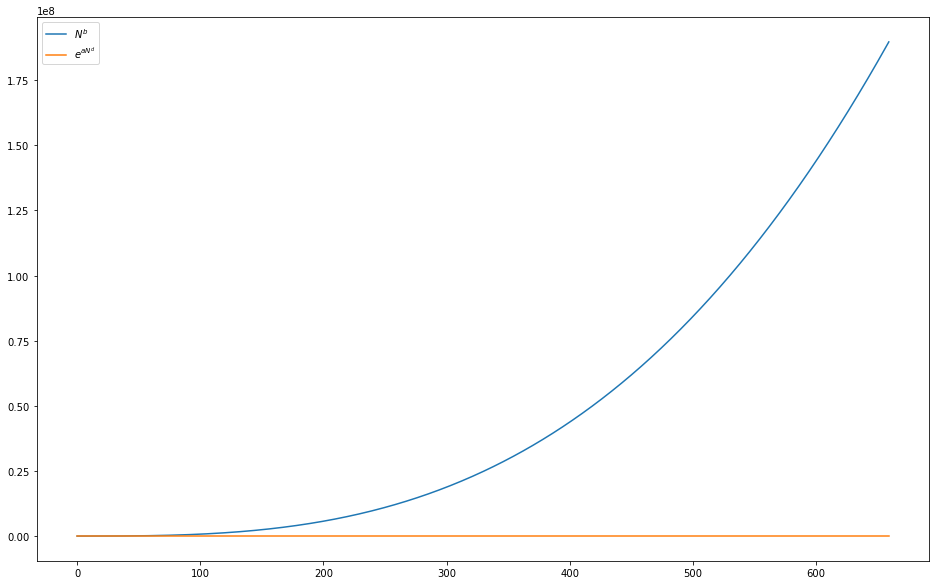

In [17]:
fig, ax = plt.subplots(figsize=(16,10))
ns = np.arange(660)
pol = ns ** popt_misch[1]
exp = np.exp(popt_misch[0] * ns ** popt_misch[3]) 
ax.plot(ns, pol, label='$N^b$')
ax.plot(ns, exp, label='$e^{a N ^d}$')
ax.legend()

ab N=60000, wird der exponentielle Teil groesser

# Wie skalieren die verschiedenen Teile des Algorithmus

[[0.11770478 0.35800758 0.67750108 0.85624338 0.90648694 0.85908707
  0.72212592]]
[0.09717035 0.13849104 0.14027554 0.09852389 0.0866668  0.13938102
 0.27714088]


Text(0, 0.5, 'Anteil')

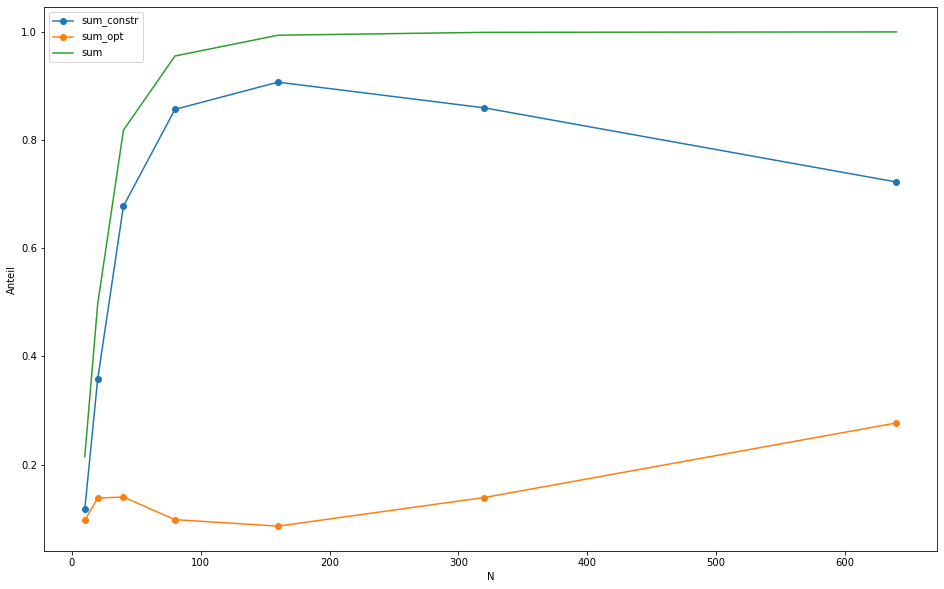

In [32]:
# Anteil des Constraintbaus an Gesamtlaufzeit
print(np.array(mean_sum_constr_3t_wob2)/np.array(mean_total_lp_3t_wob2))
# Anteil der Gurobioptimierungen an Gesamtlaufzeit
print(np.array(mean_sum_opt_3t_wob2)/np.array(mean_total_lp_3t_wob2))

anteil_constr = (np.array(mean_sum_constr_3t_wob2)/np.array(mean_total_lp_3t_wob2)).flatten()
anteil_opt = (np.array(mean_sum_opt_3t_wob2)/np.array(mean_total_lp_3t_wob2)).flatten()
fig, ax = plt.subplots(figsize=(16,10))
ax.plot(np.array(ns_3t_wob2), anteil_constr, 'o-', label='sum_constr')
ax.plot(np.array(ns_3t_wob2), anteil_opt, 'o-', label='sum_opt')
ax.plot(ns_3t_wob2, anteil_constr+anteil_opt, label='sum')
ax.legend()
ax.set_xlabel('N')
ax.set_ylabel('Anteil')

Es ist so, dass in Summe das hinzufügen von Constraints bisher den Hauptteil der Laufzeit benötigt hat. Man erkennt aber, dass je größer das System wird, desto mehr Gesamtrechenzeit wird für die LP-Optimierungsberechnung benötigt. Ich gehe davon aus, dass dieser Anteil (der sich ja aus der Summe der opt-Berechnung aller Iterationen zusammensetzt) irgendwann dominant wird und die Gesamtlaufzeit für unendlich große Systeme festlegt.


# wie wächst in einer Simulation die Laufzeit vom gurobi-optimize mit wachsender constraint Zahl
Achtung: die Darstellung ist nur von einer einzelnen Simulation, das sieht für jede anders aus

Text(0, 0.5, 'Laufzeit[ms]')

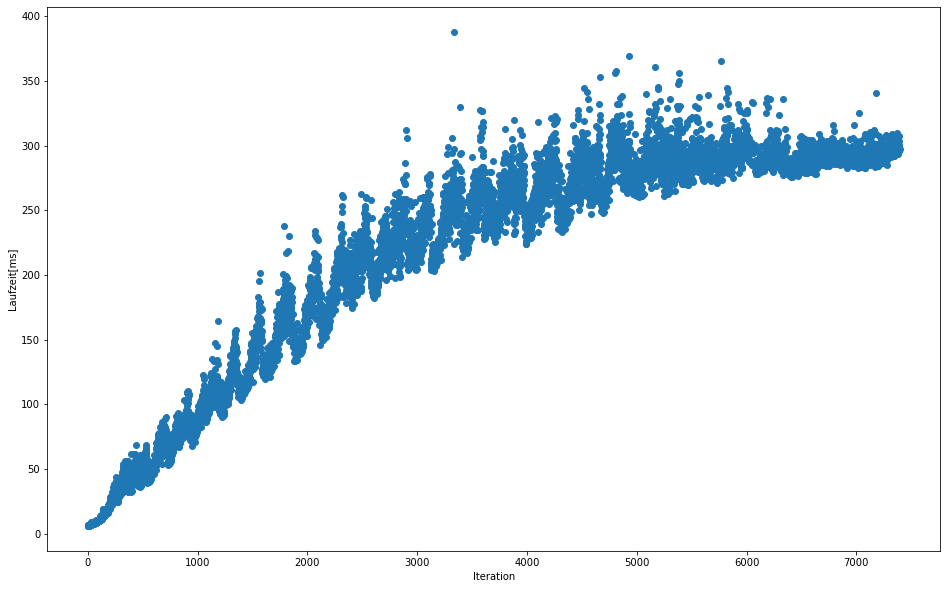

In [25]:
i=1
opt = np.loadtxt(os.path.join(r'D:\Uni\Masterarbeit\Daten\Track\Track_woB2_C3_640_nodes_5_scenarios\TreePlusC_3.000000_c_640_nodes_5_RandomScenarioCreator_RandomTestCreator_0.000000_10.000000\simulation_0\Tracking', 'opt', f'{i}_ms.txt'))
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(np.arange(len(opt[1:])), opt[1:])
# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Laufzeit[ms]')

# Anteil an ganzzahligen LP-Variablen

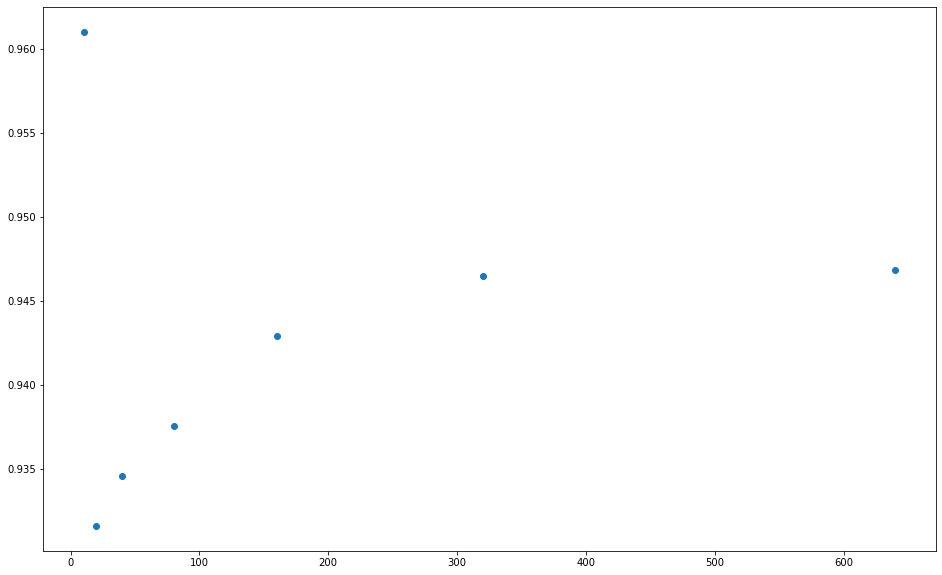

In [3]:
fig, ax = plt.subplots(figsize=(16,10))
ax.scatter(ns_3t_wob2, mean_anteil_lp_ganz_3t_wob2)

Fällt zu Beginn von 1 ab und dann steigt der Anteil wieder. Ich denke, aber dass das auch daran liegt, dass es einfach immer mehr Variablen gibt. Für jede Kante kommen k+1 LP-Variablen dazu. Man benötigt, aber für einen Baum immer nur n-1 Kanten, und es können auch viele lp-variablen einfach 0 bleiben und zählen trotzdem hier als ganzzahlig mit rein